In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers, models, layers, callbacks
from sklearn.utils import class_weight

from prosenet import ProSeNet, PrototypeProjection, datasets, ops

In [2]:
# Dataset parameters

num_classes = 3
sequence_length = 200
num_features = 1

In [3]:
# Set any non-default args
new_rnn_args = {
    'layers' : [8],
    'layer_args' : {
        'dropout' : 0.1,
        'activity_regularizer' : regularizers.l2(0.1)    # Note: not in paper
    }
}

new_proto_args = {
    'dmin' : 2.0,
    'Ld' : 0.1, #0.1,
    'Lc' : 0.01,
    'Le' : 0.1
}

pnet = ProSeNet(input_shape=(sequence_length, num_features), 
                nclasses=num_classes, 
                k=12, 
                rnn_args=new_rnn_args,
                prototypes_args=new_proto_args,
                L1=0.1)

pnet.build( (None, sequence_length, num_features) )

pnet.summary()

Model: "pro_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 16)                640       
_________________________________________________________________
prototypes (Prototypes)      multiple                  192       
_________________________________________________________________
classifier (Dense)           multiple                  36        
Total params: 868
Trainable params: 868
Non-trainable params: 0
_________________________________________________________________


In [4]:
data = datasets.SyntheticSignalsDataset(examples_per_class=500)
data.load_data()

data.X_train.shape, data.y_train.shape, data.X_test.shape, data.y_test.shape

((1200, 200, 1), (1200, 3), (300, 200, 1), (300, 3))

In [5]:
train_gen = datasets.DataGenerator(data.X_train, data.y_train, batch_size=128)

test_gen = datasets.DataGenerator(data.X_test, data.y_test, batch_size=128)

class_weights = 1 - (np.bincount(np.argmax(data.y_train, 1)) / data.y_train.shape[0])

# Setting class 0 to 0.001, need to just get it to stop overfitting that class
#class_weights[0] = 0.0
class_weights

array([0.6725    , 0.66583333, 0.66166667])

# First train just the `encoder`

In [6]:
x_encoded = pnet.encoder.output

pred = layers.Dense(3, activation='softmax')(x_encoded)

encoder_classifier = models.Model(inputs=pnet.encoder.input, outputs=pred)

encoder_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 1)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                640       
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________


In [7]:
rms = optimizers.RMSprop()

encoder_classifier.trainable = True

encoder_classifier.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])

encoder_classifier.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=25,
                   shuffle=False)

Epoch 1/25
10/10 [==============================] - 2s 180ms/step - loss: 1.0505 - accuracy: 0.5400 - val_loss: 1.0188 - val_accuracy: 0.6200
Epoch 2/25
10/10 [==============================] - 1s 51ms/step - loss: 1.0122 - accuracy: 0.6075 - val_loss: 0.9860 - val_accuracy: 0.6900
Epoch 3/25
10/10 [==============================] - 0s 45ms/step - loss: 0.9783 - accuracy: 0.6808 - val_loss: 0.9536 - val_accuracy: 0.7800
Epoch 4/25
10/10 [==============================] - 0s 47ms/step - loss: 0.9482 - accuracy: 0.8417 - val_loss: 0.9205 - val_accuracy: 0.8300
Epoch 5/25
10/10 [==============================] - 0s 49ms/step - loss: 0.9108 - accuracy: 0.8708 - val_loss: 0.8793 - val_accuracy: 0.9367
Epoch 6/25
10/10 [==============================] - 0s 49ms/step - loss: 0.8603 - accuracy: 0.9592 - val_loss: 0.8251 - val_accuracy: 0.8767
Epoch 7/25
10/10 [==============================] - 1s 51ms/step - loss: 0.8124 - accuracy: 0.9100 - val_loss: 0.7831 - val_accuracy: 0.7900
Epoch 8/25
1

# Now freeze the `encoder`

In [8]:
pnet.encoder.trainable = False

In [9]:
# Define come `Callback`s

init_lr = 0.01 # 1.0

def lr_schedule(epoch):
    if epoch <= 10:
        return init_lr
    else:
        return init_lr * 0.85**(epoch - 10)
    
lr_schedule = callbacks.LearningRateScheduler(lr_schedule)

early_stopping = callbacks.EarlyStopping(patience=3)

projection = PrototypeProjection(train_gen, freq=4)

In [10]:
sgd = optimizers.SGD(learning_rate=init_lr, clipnorm=5.0)

pnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

pnet.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=15,
                   callbacks=[early_stopping, lr_schedule, projection],
                   shuffle=False)

Epoch 1/15
 9/10 [==========================>...] - ETA: 0s - loss: 18.1495 - accuracy: 0.3455
Computing prototype projection...
... assigned new prototypes from projections.
10/10 [==============================] - 2s 172ms/step - loss: 17.2036 - accuracy: 0.3435 - val_loss: 1.6553 - val_accuracy: 0.3300
Epoch 2/15
10/10 [==============================] - 1s 56ms/step - loss: 8.4795 - accuracy: 0.5163 - val_loss: 1.5740 - val_accuracy: 0.4900
Epoch 3/15
10/10 [==============================] - 0s 50ms/step - loss: 7.3874 - accuracy: 0.5038 - val_loss: 1.5553 - val_accuracy: 0.5033
Epoch 4/15
10/10 [==============================] - 1s 55ms/step - loss: 6.7317 - accuracy: 0.4972 - val_loss: 1.5394 - val_accuracy: 0.5033
Epoch 5/15
 9/10 [==========================>...] - ETA: 0s - loss: 6.4929 - accuracy: 0.5010
Computing prototype projection...
... assigned new prototypes from projections.
10/10 [==============================] - 1s 76ms/step - loss: 6.3203 - accuracy: 0.5030 - val_lo

# Diagnostics

In [11]:
# Encoding layer(s) output
pnet.encoder.predict(data.X_train[np.newaxis, 0], batch_size=1)

array([[-0.316839  , -0.4693163 ,  0.5380069 , -0.19191603,  0.28488824,
         0.04541259,  0.18359849,  0.53131217, -0.19318098,  0.23849864,
        -0.27405536, -0.33733866,  0.43038473,  0.24915837, -0.13070036,
         0.29243013]], dtype=float32)

-0.6829214 0.7678912


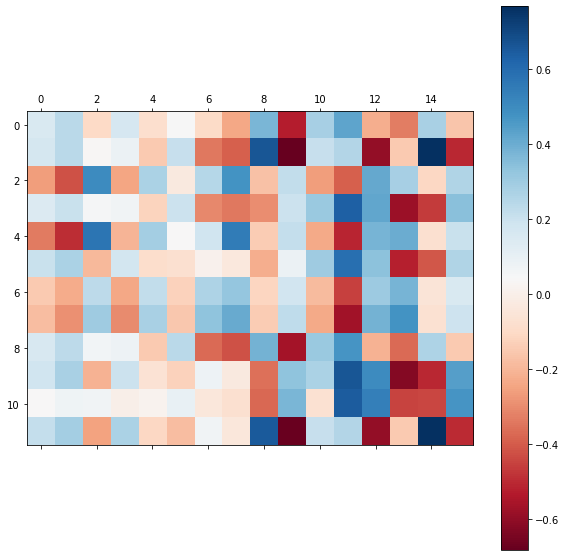

In [12]:
# Prototype layer weights
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
print(protos.min(), protos.max())

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(protos, cmap=plt.cm.RdBu)
fig.colorbar(cax, ax=ax)

0.0 0.47078842


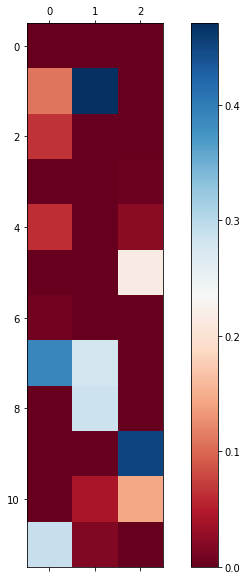

In [13]:
pred_weights = np.squeeze(pnet.classifier.weights[0].numpy())
print(pred_weights.min(), pred_weights.max())

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(pred_weights, cmap=plt.cm.RdBu)
fig.colorbar(cax)

In [18]:
pnet.predict(data.X_train[:3,:], batch_size=1)

array([[0.37355912, 0.32801726, 0.29842365],
       [0.38386393, 0.3290254 , 0.2871107 ],
       [0.38746673, 0.33229753, 0.28023577]], dtype=float32)

In [19]:
data.y_train[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [20]:
pnet.predict(data.X_test[-3:,:], batch_size=1)

array([[0.2895558 , 0.31298056, 0.39746362],
       [0.2884386 , 0.31169042, 0.399871  ],
       [0.31417403, 0.417354  , 0.268472  ]], dtype=float32)

In [21]:
data.y_test[-3:]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

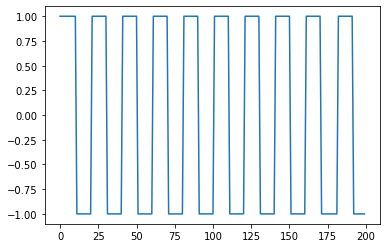

In [22]:
plt.plot(np.arange(200), data.X_train[-2])

In [23]:
pnet.classifier.weights[0]

<tf.Variable 'classifier/kernel:0' shape=(12, 3) dtype=float32, numpy=
array([[0.0000000e+00, 3.2467517e-04, 0.0000000e+00],
       [1.0953260e-01, 4.7078842e-01, 0.0000000e+00],
       [6.6130646e-02, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 5.3521148e-03],
       [6.2379647e-02, 0.0000000e+00, 2.3488518e-02],
       [0.0000000e+00, 0.0000000e+00, 2.1571557e-01],
       [9.0649677e-03, 0.0000000e+00, 0.0000000e+00],
       [3.8845047e-01, 2.7934647e-01, 0.0000000e+00],
       [0.0000000e+00, 2.8521588e-01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 4.5170930e-01],
       [0.0000000e+00, 4.2916279e-02, 1.4458661e-01],
       [2.8953439e-01, 1.6807571e-02, 0.0000000e+00]], dtype=float32)>

In [24]:
encoder_classifier.layers[-1].weights

[<tf.Variable 'dense/kernel:0' shape=(16, 3) dtype=float32, numpy=
 array([[-0.22278406, -0.04005273,  0.32528096],
        [-0.603817  ,  0.26458955,  0.3604902 ],
        [ 0.40229654, -0.5003784 , -0.6207006 ],
        [ 0.23789   ,  0.5355962 ,  0.09878284],
        [ 0.16279262, -0.45576993, -0.35205734],
        [-0.2922295 , -0.2604457 ,  0.5086053 ],
        [ 0.09458225, -0.51006514, -0.3957145 ],
        [ 0.5249681 , -0.53352654, -0.2928095 ],
        [ 0.1659744 ,  0.52869403, -0.742845  ],
        [ 0.34957924, -0.7623362 ,  0.2790925 ],
        [-0.3119695 ,  0.387664  ,  0.4450217 ],
        [-0.5589899 ,  0.4216394 ,  0.7230646 ],
        [ 0.5714559 , -0.43220693,  0.04762669],
        [ 0.38471583, -0.08036952, -0.47103578],
        [-0.1689946 ,  0.52039003, -0.5688088 ],
        [ 0.49436602, -0.5392497 ,  0.7708549 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(3,) dtype=float32, numpy=array([-0.06705799, -0.09360906,  0.09815807], dtype=float32)>]

In [25]:
pnet.prototypes_layer._diversity_term()

<tf.Tensor: id=383847, shape=(), dtype=float32, numpy=18.820484>

In [26]:
pnet.encoder.predict(data.X_train[np.newaxis, 0], batch_size=1)

array([[-0.316839  , -0.4693163 ,  0.5380069 , -0.19191603,  0.28488824,
         0.04541259,  0.18359849,  0.53131217, -0.19318098,  0.23849864,
        -0.27405536, -0.33733866,  0.43038473,  0.24915837, -0.13070036,
         0.29243013]], dtype=float32)